### Preparation

In [160]:
import numpy as np
from sympy import *
from sympy.physics.quantum import TensorProduct
import warnings
from scipy.linalg import solve_continuous_lyapunov
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
init_printing(use_unicode=True)

# ------- Simulation -------
def simulate_M(bernoulli_matrix: Array, seed: int, p: int) -> Array:
    normal_matrix = np.random.normal(0, 1, (p, p))
    temp_M = bernoulli_matrix * normal_matrix
    for i in range(p): # adjust diagonal entries s.t. M stable
        row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
        temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])
    return temp_M

# ------- commutation matrix -------
# sympy follows column-major style, numpy row-,amjor -> reshape with different order
def comm_mat(m, n):
    w = np.arange(m * n).reshape((m, n), order="F").T.ravel(order="F")
    return np.eye(m * n)[w, :]
def comm_mat_sympy(m, n):
    w = Matrix(range(m * n)).reshape(n, m).T.reshape(m * n, 1)
    return eye(m * n).extract(w, list(range(m * n)))

# ------- matrix A(Sigma) -------
def create_A_Sigma(cov: Array, p: int) -> Array:
    identity = eye(p)
    return np.kron(cov, identity) + np.matmul(np.kron(identity, cov), comm_mat(p, p))
def create_A_Sigma_sympy(cov: Matrix, p: int) -> Matrix:
    identity = eye(p)
    return TensorProduct(cov, identity) + TensorProduct(identity, cov) * comm_mat_sympy(p, p)

# ------- matrix A (intervention) -------
def create_A(A_Sigma: Array, mean: Array, p: int) -> Array:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = np.hstack((identity, mean[i] * eye(p)))
    return np.vstack((A_Sigma, identity))
def create_A_sympy(A_Sigma: Matrix, mean: Matrix, p: int) -> Matrix:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = Matrix.hstack(identity, mean[i] * eye(p))
    return Matrix.vstack(A_Sigma, identity)

# ------- Gram matrix -------
def gram(A: Array) -> Array:
    return np.matmul(np.transpose(A), A)
def gram_sympy(A: Matrix) -> Matrix:
    return A.T * A

# ------- vector g -------
def vec_g(A: Array, vec_C: Array) -> Array:
    return - np.dot(A, vec_C)
def vec_g_sympy(A: Matrix, vec_C: Matrix) -> Matrix:
    return - A * vec_C

# ------- irrepresentability condition -------
def irrep_cond(A: Array, supp: Array, supp_compl: Array) -> float:
    gram_matrix = gram(A=A)
    try:
        matrix_1 = gram_matrix[supp_compl[:, None], supp] # uses broadcasting
        matrix_2 = np.linalg.inv(gram_matrix[supp[:, None], supp])
        return np.linalg.norm(np.matmul(matrix_1, matrix_2), ord=np.inf)
    except np.linalg.LinAlgError:
        return -1

# ------- weak irrepresentability condition -------
def weak_irrep_cond(M: Array, A: Array, supp: Array, supp_compl: Array) -> float:
    gram_matrix = gram(A=A)
    try:
        matrix_1 = gram_matrix[supp_compl[:, None], supp] # uses broadcasting
        matrix_2 = np.linalg.inv(gram_matrix[supp[:, None], supp])
        sign_vec = np.sign(M.flatten(order="F"))[supp]
        return np.linalg.norm(np.matmul(matrix_1, matrix_2) @ sign_vec, ord=np.inf)
    except np.linalg.LinAlgError:
        return -1

num_exp = 1000 # number of true matrices per case
num_sim = 1000 # number of simulations per true matrix

index_intervention = 0
b = 2

### $S^C = \emptyset$: How does the irrepresentability condition look like?

### 3 nodes - Irrepresentability condition

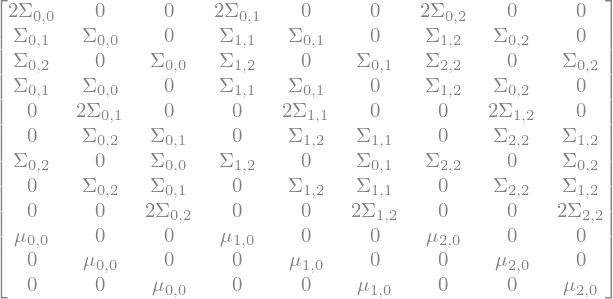

In [113]:
p = 3
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [150]:
p = 3
offset = 120899
d = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
full_support = np.arange(p * p)

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

irrep_3 = np.empty(shape=(num_exp, len(d)), dtype=object)

for index in range(len(d)):
    for seed in range(offset, num_exp + offset):
        np.random.seed(seed=seed)
        bernoulli_matrix = np.random.binomial(1, d[index], (p, p))

        support = (np.nonzero(bernoulli_matrix.flatten() != 0))[0]
        for i in range(p):
            if ((i * p) + i) not in support:
                support = np.append(support, (i * p) + i)
        supp_compl = np.setdiff1d(full_support, support)

        if len(supp_compl) == 0:
            irrep_3[seed - offset, index] = -2
        
        else:
            true_M = simulate_M(bernoulli_matrix=bernoulli_matrix, seed=seed, p=p)

            true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
            true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

            obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
            emp_cov = np.cov(obs, rowvar=False)
            emp_mean = np.mean(obs, axis=0)

            emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
            emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
            emp_A = np.float64(emp_A)

            irrep_condition = irrep_cond(A=emp_A, supp=support, supp_compl=supp_compl)

            irrep_3[seed - offset, index] = irrep_condition

print("Complete graph: ", np.sum(irrep_3 == -2, axis=0))
print("Singular Gram matrix: ", np.sum(irrep_3 == -1, axis=0))
print("Irrepresentability condition satisfied: ", (np.sum(irrep_3 < 1, axis=0) - np.sum(irrep_3 == -2, axis=0) - np.sum(irrep_3 == -1, axis=0)))

Complete graph:  [   4   16   37  111  258  526 1000]
Singular Gram matrix:  [0 0 0 0 0 0 0]
Irrepresentability condition satisfied:  [112  67  43  25  10   2   0]


### 3 nodes - Weak irrepresentability condition

In [161]:
p = 3
offset = 120899
d = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
full_support = np.arange(p * p)

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

weak_irrep_3 = np.empty(shape=(num_exp, len(d)), dtype=object)

for index in range(len(d)):
    for seed in range(offset, num_exp + offset):
        np.random.seed(seed=seed)
        bernoulli_matrix = np.random.binomial(1, d[index], (p, p))

        support = (np.nonzero(bernoulli_matrix.flatten() != 0))[0]
        for i in range(p):
            if ((i * p) + i) not in support:
                support = np.append(support, (i * p) + i)
        supp_compl = np.setdiff1d(full_support, support)

        if len(supp_compl) == 0:
            weak_irrep_3[seed - offset, index] = -2
        
        else:
            true_M = simulate_M(bernoulli_matrix=bernoulli_matrix, seed=seed, p=p)

            true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
            true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

            obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
            emp_cov = np.cov(obs, rowvar=False)
            emp_mean = np.mean(obs, axis=0)

            emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
            emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
            emp_A = np.float64(emp_A)

            irrep_condition = weak_irrep_cond(M=true_M, A=emp_A, supp=support, supp_compl=supp_compl)

            weak_irrep_3[seed - offset, index] = irrep_condition

print("Complete graph: ", np.sum(weak_irrep_3 == -2, axis=0))
print("Singular Gram matrix: ", np.sum(weak_irrep_3 == -1, axis=0))
print("Irrepresentability condition satisfied: ", (np.sum(weak_irrep_3 <= 1, axis=0) - np.sum(weak_irrep_3 == -2, axis=0) - np.sum(weak_irrep_3 == -1, axis=0)))

Complete graph:  [   4   16   37  111  258  526 1000]
Singular Gram matrix:  [0 0 0 0 0 0 0]
Irrepresentability condition satisfied:  [629 559 453 392 308 195   0]


### 4 nodes - Irrepresentability condition

In [153]:
p = 4
offset = 120899
d = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
full_support = np.arange(p * p)

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

irrep_4 = np.empty(shape=(num_exp, len(d)), dtype=object)

for index in range(len(d)):
    for seed in range(offset, num_exp + offset):
        np.random.seed(seed=seed)
        bernoulli_matrix = np.random.binomial(1, d[index], (p, p))

        support = (np.nonzero(bernoulli_matrix.flatten() != 0))[0]
        for i in range(p):
            if ((i * p) + i) not in support:
                support = np.append(support, (i * p) + i)
        supp_compl = np.setdiff1d(full_support, support)

        if len(supp_compl) == 0:
            irrep_4[seed - offset, index] = -2
        
        else:
            true_M = simulate_M(bernoulli_matrix=bernoulli_matrix, seed=seed, p=p)

            true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
            true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

            obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
            emp_cov = np.cov(obs, rowvar=False)
            emp_mean = np.mean(obs, axis=0)

            emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
            emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
            emp_A = np.float64(emp_A)

            irrep_condition = irrep_cond(A=emp_A, supp=support, supp_compl=supp_compl)

            irrep_4[seed - offset, index] = irrep_condition

print("Complete graph: ", np.sum(irrep_4 == -2, axis=0))
print("Singular Gram matrix: ", np.sum(irrep_4 == -1, axis=0))
print("Irrepresentability condition satisfied: ", (np.sum(irrep_4 < 1, axis=0) - np.sum(irrep_4 == -2, axis=0) - np.sum(irrep_4 == -1, axis=0)))

Complete graph:  [   0    0    2   17   72  261 1000]
Singular Gram matrix:  [0 0 0 0 1 0 0]
Irrepresentability condition satisfied:  [11  2  0  0  0  0  0]


### 4 nodes - Weak irrepresentability condition

In [162]:
p = 4
offset = 120899
d = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
full_support = np.arange(p * p)

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

weak_irrep_4 = np.empty(shape=(num_exp, len(d)), dtype=object)

for index in range(len(d)):
    for seed in range(offset, num_exp + offset):
        np.random.seed(seed=seed)
        bernoulli_matrix = np.random.binomial(1, d[index], (p, p))

        support = (np.nonzero(bernoulli_matrix.flatten() != 0))[0]
        for i in range(p):
            if ((i * p) + i) not in support:
                support = np.append(support, (i * p) + i)
        supp_compl = np.setdiff1d(full_support, support)

        if len(supp_compl) == 0:
            weak_irrep_4[seed - offset, index] = -2
        
        else:
            true_M = simulate_M(bernoulli_matrix=bernoulli_matrix, seed=seed, p=p)

            true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
            true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

            obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
            emp_cov = np.cov(obs, rowvar=False)
            emp_mean = np.mean(obs, axis=0)

            emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
            emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
            emp_A = np.float64(emp_A)

            irrep_condition = weak_irrep_cond(M=true_M, A=emp_A, supp=support, supp_compl=supp_compl)

            weak_irrep_4[seed - offset, index] = irrep_condition

print("Complete graph: ", np.sum(weak_irrep_4 == -2, axis=0))
print("Singular Gram matrix: ", np.sum(weak_irrep_4 == -1, axis=0))
print("Irrepresentability condition satisfied: ", (np.sum(weak_irrep_4 <= 1, axis=0) - np.sum(weak_irrep_4 == -2, axis=0) - np.sum(weak_irrep_4 == -1, axis=0)))

Complete graph:  [   0    0    2   17   72  261 1000]
Singular Gram matrix:  [0 0 0 0 1 0 0]
Irrepresentability condition satisfied:  [365 262 169 127 108 121   0]


### 5 nodes - Irrepresentability condition

In [154]:
p = 5
offset = 120899
d = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
full_support = np.arange(p * p)

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

irrep_5 = np.empty(shape=(num_exp, len(d)), dtype=object)

for index in range(len(d)):
    for seed in range(offset, num_exp + offset):
        np.random.seed(seed=seed)
        bernoulli_matrix = np.random.binomial(1, d[index], (p, p))

        support = (np.nonzero(bernoulli_matrix.flatten() != 0))[0]
        for i in range(p):
            if ((i * p) + i) not in support:
                support = np.append(support, (i * p) + i)
        supp_compl = np.setdiff1d(full_support, support)

        if len(supp_compl) == 0:
            irrep_5[seed - offset, index] = -2
        
        else:
            true_M = simulate_M(bernoulli_matrix=bernoulli_matrix, seed=seed, p=p)

            true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
            true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

            obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
            emp_cov = np.cov(obs, rowvar=False)
            emp_mean = np.mean(obs, axis=0)

            emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
            emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
            emp_A = np.float64(emp_A)

            irrep_condition = irrep_cond(A=emp_A, supp=support, supp_compl=supp_compl)

            irrep_5[seed - offset, index] = irrep_condition

print("Complete graph: ", np.sum(irrep_5 == -2, axis=0))
print("Singular Gram matrix: ", np.sum(irrep_5 == -1, axis=0))
print("Irrepresentability condition satisfied: ", (np.sum(irrep_5 < 1, axis=0) - np.sum(irrep_5 == -2, axis=0) - np.sum(irrep_5 == -1, axis=0)))

Complete graph:  [   0    0    0    0   13  106 1000]
Singular Gram matrix:  [0 0 0 0 0 0 0]
Irrepresentability condition satisfied:  [2 0 0 0 0 0 0]


### 5 nodes - Weak irrepresentability condition

In [163]:
p = 5
offset = 120899
d = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
full_support = np.arange(p * p)

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

weak_irrep_5 = np.empty(shape=(num_exp, len(d)), dtype=object)

for index in range(len(d)):
    for seed in range(offset, num_exp + offset):
        np.random.seed(seed=seed)
        bernoulli_matrix = np.random.binomial(1, d[index], (p, p))

        support = (np.nonzero(bernoulli_matrix.flatten() != 0))[0]
        for i in range(p):
            if ((i * p) + i) not in support:
                support = np.append(support, (i * p) + i)
        supp_compl = np.setdiff1d(full_support, support)

        if len(supp_compl) == 0:
            weak_irrep_5[seed - offset, index] = -2
        
        else:
            true_M = simulate_M(bernoulli_matrix=bernoulli_matrix, seed=seed, p=p)

            true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
            true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

            obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
            emp_cov = np.cov(obs, rowvar=False)
            emp_mean = np.mean(obs, axis=0)

            emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
            emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
            emp_A = np.float64(emp_A)

            irrep_condition = weak_irrep_cond(M=true_M, A=emp_A, supp=support, supp_compl=supp_compl)

            weak_irrep_5[seed - offset, index] = irrep_condition

print("Complete graph: ", np.sum(weak_irrep_5 == -2, axis=0))
print("Singular Gram matrix: ", np.sum(weak_irrep_5 == -1, axis=0))
print("Irrepresentability condition satisfied: ", (np.sum(weak_irrep_5 <= 1, axis=0) - np.sum(weak_irrep_5 == -2, axis=0) - np.sum(weak_irrep_5 == -1, axis=0)))

Complete graph:  [   0    0    0    0   13  106 1000]
Singular Gram matrix:  [0 0 0 0 0 0 0]
Irrepresentability condition satisfied:  [166  86  49  19  20  57   0]
